# Minutes Projection Validation Analysis

This notebook validates whether **minutes projections are the bottleneck** in our fantasy point predictions.

## Questions to Answer:
1. How accurate are SportsLine's minutes projections?
2. Is our model good at predicting fantasy points **per minute**?
3. How much would perfect minutes improve our overall accuracy?
4. **Should we build a custom minutes prediction system?**

## Required Data:
- Run this after 3-5 days of games to have enough data
- Requires PROJECTED_MIN and ACTUAL_MIN columns (added Oct 29, 2025)

In [1]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from datetime import datetime, timedelta

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

print("Imports successful")

Imports successful


## 1. Load Data from S3

In [ ]:
# Load predictions data
s3 = boto3.client('s3')
BUCKET_NAME = 'nba-prediction-ibracken'

obj = s3.get_object(Bucket=BUCKET_NAME, Key='data/daily_predictions/current.parquet')
df = pd.read_parquet(BytesIO(obj['Body'].read()))

print(f"Total predictions loaded: {len(df)}")
print(f"Date range: {df['GAME_DATE'].min()} to {df['GAME_DATE'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

NoSuchKey: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.

In [3]:
# Filter to complete records (has all required data)
df_complete = df.dropna(subset=['PROJECTED_MIN', 'ACTUAL_MIN', 'MY_MODEL_PREDICTED_FP', 'ACTUAL_FP']).copy()

print(f"Complete predictions (with actual results): {len(df_complete)}")
print(f"Completion rate: {len(df_complete)/len(df)*100:.1f}%")
print(f"\nUnique players: {df_complete['PLAYER'].nunique()}")
print(f"Unique dates: {df_complete['GAME_DATE'].nunique()}")

if len(df_complete) < 50:
    print(f"\n⚠️  WARNING: Only {len(df_complete)} complete records. Recommend waiting until 100+ for reliable analysis.")
else:
    print(f"\n✅ Sufficient data for analysis ({len(df_complete)} records)")

Complete predictions (with actual results): 0
Completion rate: 0.0%

Unique players: 0
Unique dates: 0

⚠️  WARNING: Only 0 complete records. Recommend waiting until 100+ for reliable analysis.


## 2. Minutes Projection Accuracy

How good is SportsLine at predicting minutes?

In [4]:
# Calculate minutes errors
df_complete['MIN_ERROR'] = abs(df_complete['PROJECTED_MIN'] - df_complete['ACTUAL_MIN'])
df_complete['MIN_ERROR_PCT'] = (df_complete['MIN_ERROR'] / df_complete['ACTUAL_MIN']) * 100
df_complete['MIN_DIFF'] = df_complete['PROJECTED_MIN'] - df_complete['ACTUAL_MIN']  # signed difference

print("=" * 60)
print("MINUTES PROJECTION ACCURACY")
print("=" * 60)
print(f"\nMean Absolute Error (MAE):     {df_complete['MIN_ERROR'].mean():.2f} minutes")
print(f"Median Absolute Error:          {df_complete['MIN_ERROR'].median():.2f} minutes")
print(f"Standard Deviation:             {df_complete['MIN_ERROR'].std():.2f} minutes")
print(f"\nMean % Error:                   {df_complete['MIN_ERROR_PCT'].mean():.1f}%")
print(f"Median % Error:                 {df_complete['MIN_ERROR_PCT'].median():.1f}%")

print(f"\nBias (avg over/under prediction): {df_complete['MIN_DIFF'].mean():+.2f} minutes")
if df_complete['MIN_DIFF'].mean() > 1:
    print("  → SportsLine tends to OVER-project minutes")
elif df_complete['MIN_DIFF'].mean() < -1:
    print("  → SportsLine tends to UNDER-project minutes")
else:
    print("  → No systematic bias detected")

# Error distribution
print(f"\nError Distribution:")
print(f"  Within ±3 min:  {(df_complete['MIN_ERROR'] <= 3).sum():4d} ({(df_complete['MIN_ERROR'] <= 3).mean()*100:.1f}%)")
print(f"  Within ±5 min:  {(df_complete['MIN_ERROR'] <= 5).sum():4d} ({(df_complete['MIN_ERROR'] <= 5).mean()*100:.1f}%)")
print(f"  Within ±7 min:  {(df_complete['MIN_ERROR'] <= 7).sum():4d} ({(df_complete['MIN_ERROR'] <= 7).mean()*100:.1f}%)")
print(f"  Within ±10 min: {(df_complete['MIN_ERROR'] <= 10).sum():4d} ({(df_complete['MIN_ERROR'] <= 10).mean()*100:.1f}%)")
print(f"  >10 min error:  {(df_complete['MIN_ERROR'] > 10).sum():4d} ({(df_complete['MIN_ERROR'] > 10).mean()*100:.1f}%)")

MINUTES PROJECTION ACCURACY

Mean Absolute Error (MAE):     nan minutes
Median Absolute Error:          nan minutes
Standard Deviation:             nan minutes

Mean % Error:                   nan%
Median % Error:                 nan%

Bias (avg over/under prediction): +nan minutes
  → No systematic bias detected

Error Distribution:
  Within ±3 min:     0 (nan%)
  Within ±5 min:     0 (nan%)
  Within ±7 min:     0 (nan%)
  Within ±10 min:    0 (nan%)
  >10 min error:     0 (nan%)


## 3. Model Efficiency Prediction

Is our Random Forest good at predicting **fantasy points per minute**?

In [5]:
# Calculate FP per minute
df_complete['PREDICTED_FP_PER_MIN'] = df_complete['MY_MODEL_PREDICTED_FP'] / df_complete['PROJECTED_MIN']
df_complete['ACTUAL_FP_PER_MIN'] = df_complete['ACTUAL_FP'] / df_complete['ACTUAL_MIN']
df_complete['EFFICIENCY_ERROR'] = abs(df_complete['PREDICTED_FP_PER_MIN'] - df_complete['ACTUAL_FP_PER_MIN'])

print("=" * 60)
print("MODEL EFFICIENCY PREDICTION (FP per Minute)")
print("=" * 60)
print(f"\nMean Absolute Error:    {df_complete['EFFICIENCY_ERROR'].mean():.3f} FP/min")
print(f"Median Absolute Error:  {df_complete['EFFICIENCY_ERROR'].median():.3f} FP/min")
print(f"\nAvg Predicted FP/min:   {df_complete['PREDICTED_FP_PER_MIN'].mean():.3f}")
print(f"Avg Actual FP/min:      {df_complete['ACTUAL_FP_PER_MIN'].mean():.3f}")

# Correlation
correlation = df_complete['PREDICTED_FP_PER_MIN'].corr(df_complete['ACTUAL_FP_PER_MIN'])
print(f"\nCorrelation (predicted vs actual FP/min): {correlation:.3f}")

if correlation > 0.7:
    print("  ✅ Strong correlation - model is good at predicting efficiency")
elif correlation > 0.5:
    print("  ⚠️  Moderate correlation - some room for improvement")
else:
    print("  ❌ Weak correlation - efficiency prediction needs work")

MODEL EFFICIENCY PREDICTION (FP per Minute)

Mean Absolute Error:    nan FP/min
Median Absolute Error:  nan FP/min

Avg Predicted FP/min:   nan
Avg Actual FP/min:      nan

Correlation (predicted vs actual FP/min): nan
  ❌ Weak correlation - efficiency prediction needs work


## 4. Impact Analysis: What if Minutes Were Perfect?

**Key Question:** How much better would our predictions be with perfect minutes?

In [6]:
# Simulate perfect minutes scenario
df_complete['FP_WITH_PERFECT_MIN'] = df_complete['PREDICTED_FP_PER_MIN'] * df_complete['ACTUAL_MIN']

# Calculate errors
df_complete['ERROR_CURRENT'] = abs(df_complete['MY_MODEL_PREDICTED_FP'] - df_complete['ACTUAL_FP'])
df_complete['ERROR_PERFECT_MIN'] = abs(df_complete['FP_WITH_PERFECT_MIN'] - df_complete['ACTUAL_FP'])
df_complete['ERROR_IMPROVEMENT'] = df_complete['ERROR_CURRENT'] - df_complete['ERROR_PERFECT_MIN']

# Also compare against DFF baseline
df_dff = df_complete.dropna(subset=['PPG_PROJECTION']).copy()
df_dff['ERROR_DFF'] = abs(df_dff['PPG_PROJECTION'] - df_dff['ACTUAL_FP'])

improvement_pct = ((df_complete['ERROR_CURRENT'].mean() - df_complete['ERROR_PERFECT_MIN'].mean()) / df_complete['ERROR_CURRENT'].mean() * 100)

print("=" * 60)
print("IMPACT OF PERFECT MINUTES")
print("=" * 60)
print(f"\nCurrent MAE (with SportsLine minutes): {df_complete['ERROR_CURRENT'].mean():.2f} FP")
print(f"Hypothetical MAE (with perfect minutes): {df_complete['ERROR_PERFECT_MIN'].mean():.2f} FP")
print(f"\nPotential Improvement: {improvement_pct:.1f}%")
print(f"Average error reduction: {df_complete['ERROR_IMPROVEMENT'].mean():.2f} FP per prediction")

if len(df_dff) > 0:
    print(f"\n--- Comparison to DailyFantasyFuel ---")
    print(f"DFF Baseline MAE:                      {df_dff['ERROR_DFF'].mean():.2f} FP")
    print(f"Our Model (current):                   {df_dff['ERROR_CURRENT'].mean():.2f} FP")
    print(f"Our Model (with perfect minutes):      {df_dff['ERROR_PERFECT_MIN'].mean():.2f} FP")
    
    if df_dff['ERROR_PERFECT_MIN'].mean() < df_dff['ERROR_DFF'].mean():
        print(f"\n✅ With perfect minutes, we'd beat DFF by {df_dff['ERROR_DFF'].mean() - df_dff['ERROR_PERFECT_MIN'].mean():.2f} FP")
    else:
        print(f"\n⚠️  Even with perfect minutes, DFF is better by {df_dff['ERROR_PERFECT_MIN'].mean() - df_dff['ERROR_DFF'].mean():.2f} FP")

# Show players who would improve most
print(f"\nTop 10 Players Who Would Improve Most with Perfect Minutes:")
top_improvements = df_complete.nlargest(10, 'ERROR_IMPROVEMENT')[['PLAYER', 'PROJECTED_MIN', 'ACTUAL_MIN', 'ERROR_CURRENT', 'ERROR_PERFECT_MIN', 'ERROR_IMPROVEMENT']]
print(top_improvements.to_string(index=False))

IMPACT OF PERFECT MINUTES

Current MAE (with SportsLine minutes): nan FP
Hypothetical MAE (with perfect minutes): nan FP

Potential Improvement: nan%
Average error reduction: nan FP per prediction

Top 10 Players Who Would Improve Most with Perfect Minutes:
Empty DataFrame
Columns: [PLAYER, PROJECTED_MIN, ACTUAL_MIN, ERROR_CURRENT, ERROR_PERFECT_MIN, ERROR_IMPROVEMENT]
Index: []


## 5. Visualizations


✅ Visualization saved to images/minutes_validation_analysis.png


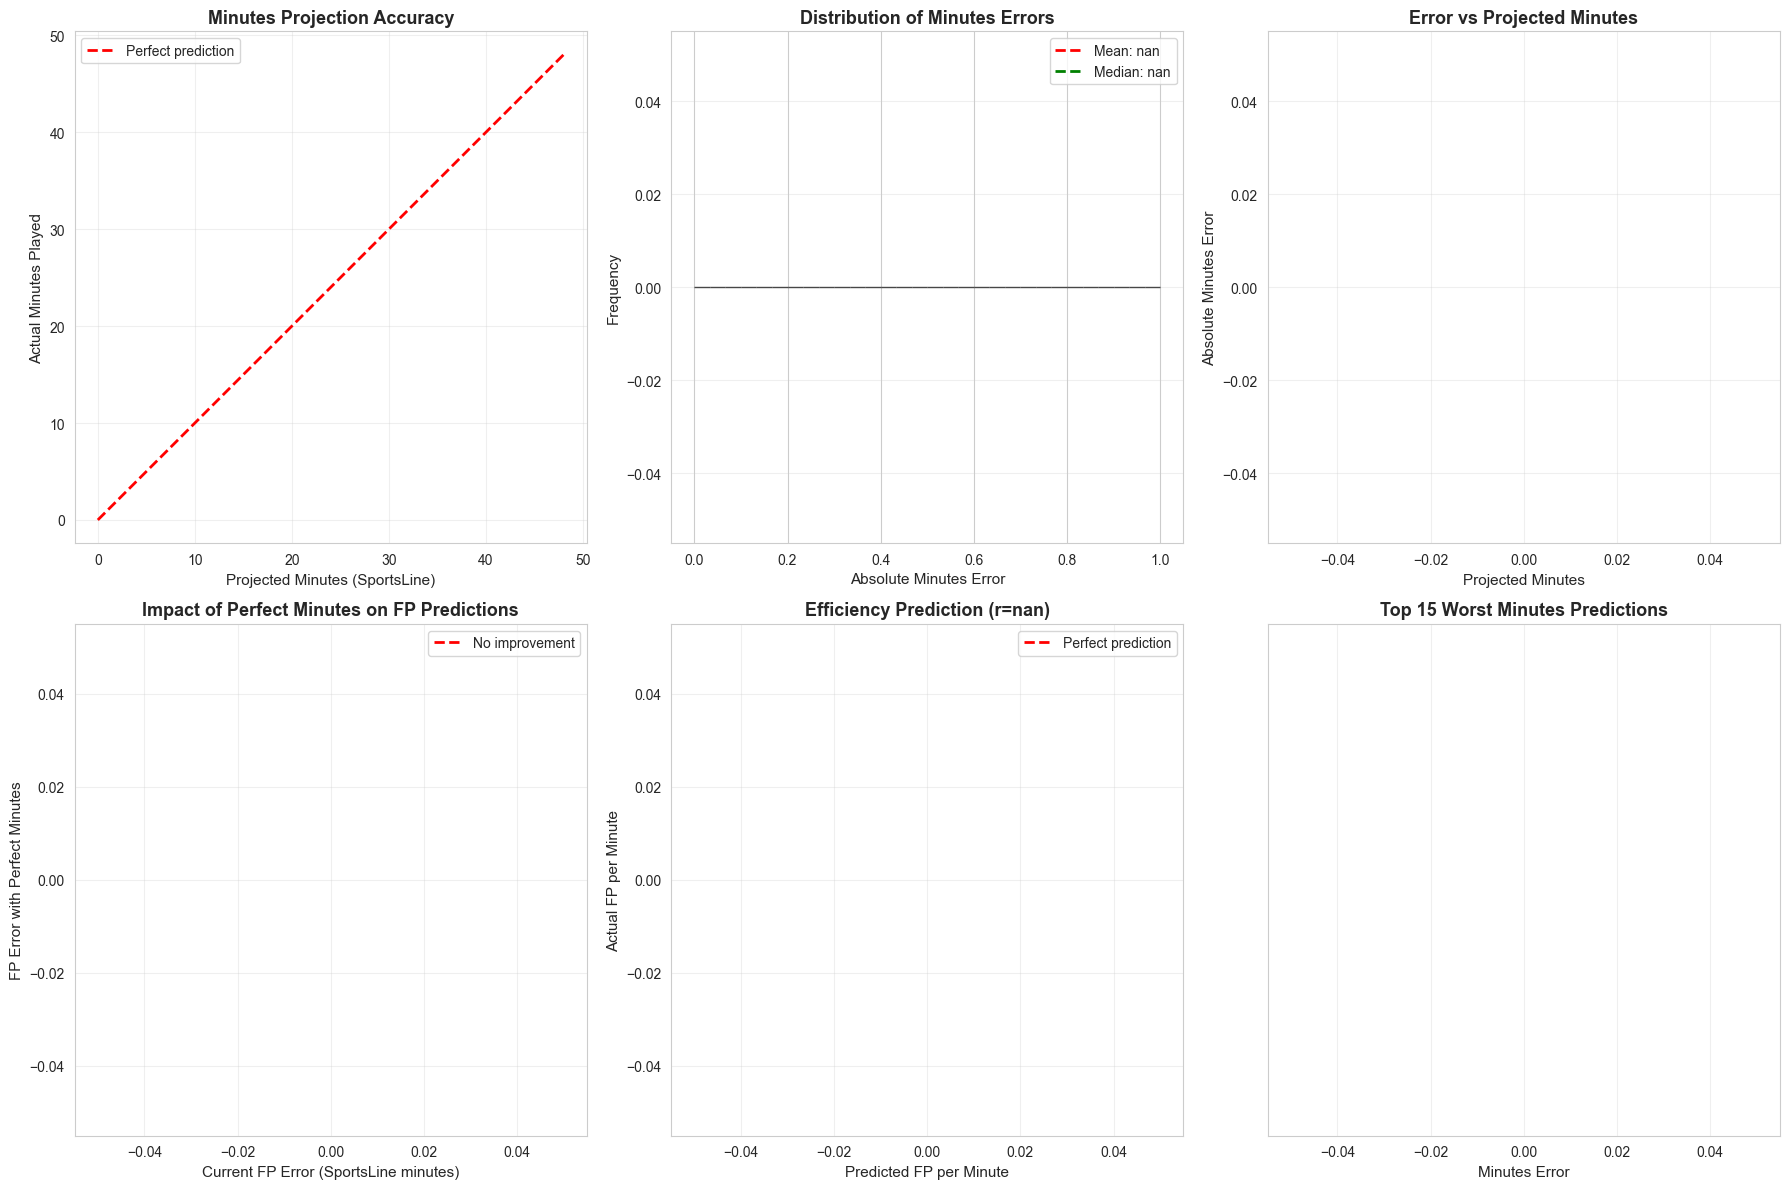

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Projected vs Actual Minutes (scatter)
axes[0, 0].scatter(df_complete['PROJECTED_MIN'], df_complete['ACTUAL_MIN'], alpha=0.5, s=30)
axes[0, 0].plot([0, 48], [0, 48], 'r--', linewidth=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Projected Minutes (SportsLine)', fontsize=11)
axes[0, 0].set_ylabel('Actual Minutes Played', fontsize=11)
axes[0, 0].set_title('Minutes Projection Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Minutes Error Distribution
axes[0, 1].hist(df_complete['MIN_ERROR'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df_complete['MIN_ERROR'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_complete["MIN_ERROR"].mean():.1f}')
axes[0, 1].axvline(df_complete['MIN_ERROR'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_complete["MIN_ERROR"].median():.1f}')
axes[0, 1].set_xlabel('Absolute Minutes Error', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Minutes Errors', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Minutes Error by Projected Minutes (does error increase for high-minute players?)
axes[0, 2].scatter(df_complete['PROJECTED_MIN'], df_complete['MIN_ERROR'], alpha=0.5, s=30)
axes[0, 2].set_xlabel('Projected Minutes', fontsize=11)
axes[0, 2].set_ylabel('Absolute Minutes Error', fontsize=11)
axes[0, 2].set_title('Error vs Projected Minutes', fontsize=13, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. FP Error: Current vs Perfect Minutes
axes[1, 0].scatter(df_complete['ERROR_CURRENT'], df_complete['ERROR_PERFECT_MIN'], alpha=0.5, s=30)
max_error = max(df_complete['ERROR_CURRENT'].max(), df_complete['ERROR_PERFECT_MIN'].max())
axes[1, 0].plot([0, max_error], [0, max_error], 'r--', linewidth=2, label='No improvement')
axes[1, 0].set_xlabel('Current FP Error (SportsLine minutes)', fontsize=11)
axes[1, 0].set_ylabel('FP Error with Perfect Minutes', fontsize=11)
axes[1, 0].set_title('Impact of Perfect Minutes on FP Predictions', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Efficiency Prediction (FP per minute)
axes[1, 1].scatter(df_complete['PREDICTED_FP_PER_MIN'], df_complete['ACTUAL_FP_PER_MIN'], alpha=0.5, s=30)
max_fp_min = max(df_complete['PREDICTED_FP_PER_MIN'].max(), df_complete['ACTUAL_FP_PER_MIN'].max())
axes[1, 1].plot([0, max_fp_min], [0, max_fp_min], 'r--', linewidth=2, label='Perfect prediction')
axes[1, 1].set_xlabel('Predicted FP per Minute', fontsize=11)
axes[1, 1].set_ylabel('Actual FP per Minute', fontsize=11)
axes[1, 1].set_title(f'Efficiency Prediction (r={correlation:.3f})', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Top 15 worst minutes predictions
worst_15 = df_complete.nlargest(15, 'MIN_ERROR')[['PLAYER', 'PROJECTED_MIN', 'ACTUAL_MIN', 'MIN_ERROR']].copy()
worst_15 = worst_15.sort_values('MIN_ERROR')
y_pos = np.arange(len(worst_15))
axes[1, 2].barh(y_pos, worst_15['MIN_ERROR'], alpha=0.7)
axes[1, 2].set_yticks(y_pos)
axes[1, 2].set_yticklabels([name[:15] for name in worst_15['PLAYER']], fontsize=9)
axes[1, 2].set_xlabel('Minutes Error', fontsize=11)
axes[1, 2].set_title('Top 15 Worst Minutes Predictions', fontsize=13, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../images/minutes_validation_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved to images/minutes_validation_analysis.png")
plt.show()

## 6. Time Series Analysis (Are errors getting worse over time?)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

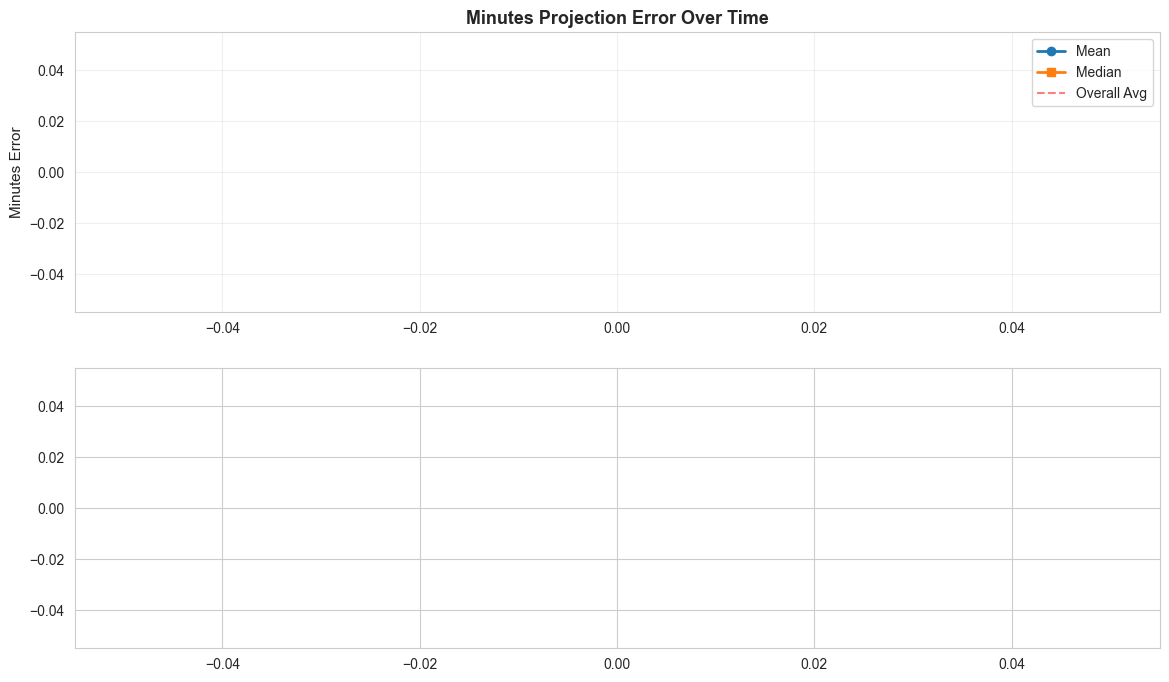

In [8]:
# Group by date
daily_stats = df_complete.groupby('GAME_DATE').agg({
    'MIN_ERROR': ['mean', 'median'],
    'ERROR_CURRENT': 'mean',
    'ERROR_PERFECT_MIN': 'mean',
    'PLAYER': 'count'
}).reset_index()

daily_stats.columns = ['DATE', 'MIN_ERROR_MEAN', 'MIN_ERROR_MEDIAN', 'FP_ERROR_CURRENT', 'FP_ERROR_PERFECT', 'NUM_PLAYERS']

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Minutes error over time
axes[0].plot(daily_stats['DATE'], daily_stats['MIN_ERROR_MEAN'], marker='o', linewidth=2, label='Mean')
axes[0].plot(daily_stats['DATE'], daily_stats['MIN_ERROR_MEDIAN'], marker='s', linewidth=2, label='Median')
axes[0].axhline(daily_stats['MIN_ERROR_MEAN'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall Avg')
axes[0].set_ylabel('Minutes Error', fontsize=11)
axes[0].set_title('Minutes Projection Error Over Time', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# FP error comparison over time
axes[1].plot(daily_stats['DATE'], daily_stats['FP_ERROR_CURRENT'], marker='o', linewidth=2, label='Current (SportsLine min)')
axes[1].plot(daily_stats['DATE'], daily_stats['FP_ERROR_PERFECT'], marker='s', linewidth=2, label='With Perfect Minutes')
axes[1].fill_between(daily_stats['DATE'], daily_stats['FP_ERROR_CURRENT'], daily_stats['FP_ERROR_PERFECT'], alpha=0.3, label='Improvement Potential')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('FP Error (MAE)', fontsize=11)
axes[1].set_title('Fantasy Point Prediction Error Over Time', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/minutes_time_series.png', dpi=300, bbox_inches='tight')
print("\n✅ Time series saved to images/minutes_time_series.png")
plt.show()

print("\nDaily Statistics:")
print(daily_stats.to_string(index=False))

## 7. FINAL RECOMMENDATION

Decision matrix based on data analysis

In [ ]:
print("=" * 70)
print("FINAL RECOMMENDATION: SHOULD WE BUILD A MINUTES PREDICTION SYSTEM?")
print("=" * 70)

mae_threshold = 7.0  # minutes
improvement_threshold = 15.0  # percent
efficiency_threshold = 0.6  # correlation

minutes_mae = df_complete['MIN_ERROR'].mean()
efficiency_corr = df_complete['PREDICTED_FP_PER_MIN'].corr(df_complete['ACTUAL_FP_PER_MIN'])

print(f"\nKey Metrics:")
print(f"  Minutes MAE:           {minutes_mae:.2f} min (threshold: {mae_threshold})")
print(f"  Improvement Potential: {improvement_pct:.1f}% (threshold: {improvement_threshold}%)")
print(f"  Efficiency Correlation: {efficiency_corr:.3f} (threshold: {efficiency_threshold})")

print(f"\nDecision Tree:")

if minutes_mae > mae_threshold and improvement_pct > improvement_threshold:
    print("\n" + "="*70)
    print("✅ STRONG YES: BUILD MINUTES PREDICTION SYSTEM")
    print("="*70)
    print(f"\nReasons:")
    print(f"  • Minutes projections are inaccurate (MAE = {minutes_mae:.1f} min)")
    print(f"  • High improvement potential ({improvement_pct:.1f}%)")
    print(f"  • This is clearly the bottleneck in your predictions")
    print(f"\nNext Steps:")
    print(f"  1. Build minutes prediction model (Random Forest)")
    print(f"  2. Features: season avg, last 5 games, injuries, starter status, rest days")
    print(f"  3. Scrape injury reports and game spreads")
    print(f"  4. Target: Reduce MAE from {minutes_mae:.1f} to <5 minutes")
    print(f"  5. Expected FP MAE improvement: {df_complete['ERROR_CURRENT'].mean():.1f} → {df_complete['ERROR_PERFECT_MIN'].mean():.1f}")
    
elif minutes_mae > mae_threshold and improvement_pct <= improvement_threshold:
    print("\n" + "="*70)
    print("⚠️  MAYBE: MINUTES ARE BAD BUT NOT THE MAIN BOTTLENECK")
    print("="*70)
    print(f"\nReasons:")
    print(f"  • Minutes projections are inaccurate (MAE = {minutes_mae:.1f} min)")
    print(f"  • But improvement potential is modest ({improvement_pct:.1f}%)")
    if efficiency_corr < efficiency_threshold:
        print(f"  • Efficiency prediction is weak (r = {efficiency_corr:.3f})")
        print(f"  • THIS is likely the real bottleneck")
    print(f"\nNext Steps:")
    print(f"  1. First, improve efficiency (FP/min) prediction")
    print(f"     - Review feature engineering")
    print(f"     - Check if clusters are meaningful")
    print(f"     - Consider additional features (recent form, usage rate)")
    print(f"  2. Then revisit minutes prediction later")
    
elif minutes_mae <= mae_threshold:
    print("\n" + "="*70)
    print("❌ NO: DON'T BUILD MINUTES SYSTEM (IT'S GOOD ENOUGH)")
    print("="*70)
    print(f"\nReasons:")
    print(f"  • Minutes projections are reasonably accurate (MAE = {minutes_mae:.1f} min)")
    print(f"  • Improvement potential is limited ({improvement_pct:.1f}%)")
    print(f"  • Focus elsewhere for bigger gains")
    print(f"\nNext Steps:")
    if efficiency_corr < efficiency_threshold:
        print(f"  1. Improve efficiency (FP/min) prediction (weak correlation: {efficiency_corr:.3f})")
    print(f"  2. Add new features: recent matchup history, pace, usage rate")
    print(f"  3. Explore other models: XGBoost, LightGBM")
    print(f"  4. Build a frontend to showcase your work")
    
else:
    print("\n⚠️  EDGE CASE - Manual review recommended")

print("\n" + "="*70)
print(f"Analysis complete! Analyzed {len(df_complete)} predictions.")
print("="*70)

## 8. Export Summary Report

In [ ]:
# Create summary report
report = f"""
MINUTES VALIDATION ANALYSIS REPORT
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
{'='*70}

DATA SUMMARY:
  Total predictions:      {len(df)}
  Complete predictions:   {len(df_complete)}
  Date range:             {df_complete['GAME_DATE'].min()} to {df_complete['GAME_DATE'].max()}
  Unique players:         {df_complete['PLAYER'].nunique()}

MINUTES PROJECTION ACCURACY:
  Mean Absolute Error:    {df_complete['MIN_ERROR'].mean():.2f} minutes
  Median Absolute Error:  {df_complete['MIN_ERROR'].median():.2f} minutes
  Mean % Error:           {df_complete['MIN_ERROR_PCT'].mean():.1f}%
  Within ±5 min:          {(df_complete['MIN_ERROR'] <= 5).mean()*100:.1f}%
  Within ±10 min:         {(df_complete['MIN_ERROR'] <= 10).mean()*100:.1f}%

EFFICIENCY PREDICTION:
  FP/min correlation:     {efficiency_corr:.3f}
  Mean efficiency error:  {df_complete['EFFICIENCY_ERROR'].mean():.3f} FP/min

IMPACT ANALYSIS:
  Current FP MAE:         {df_complete['ERROR_CURRENT'].mean():.2f} FP
  With perfect minutes:   {df_complete['ERROR_PERFECT_MIN'].mean():.2f} FP
  Improvement potential:  {improvement_pct:.1f}%

RECOMMENDATION:
  Minutes MAE > {mae_threshold}:        {'YES' if minutes_mae > mae_threshold else 'NO'}
  Improvement > {improvement_threshold}%:      {'YES' if improvement_pct > improvement_threshold else 'NO'}
  
  {'BUILD MINUTES SYSTEM' if (minutes_mae > mae_threshold and improvement_pct > improvement_threshold) else 'FOCUS ELSEWHERE'}
"""

print(report)

# Save to file
with open(f'../minutes_validation_report_{datetime.now().strftime("%Y%m%d")}.txt', 'w') as f:
    f.write(report)

print(f"\n✅ Report saved to minutes_validation_report_{datetime.now().strftime('%Y%m%d')}.txt")